In [1]:
# Just the normal prequisites for using matplotlib and numpy in a Jupyter notebook
%matplotlib inline
# Use the svg backend, in my opinion it just makes better looking plots
%config InlineBackend.figure_format = 'svg'

import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging( logging_level='DEBUG')

import os
import sys
from pathlib import Path
import IPython
from scipy import signal
import scipy.fftpack
from PySpice.Unit import *
from PySpice.Spice.Parser import SpiceParser
from PySpice.Spice.Netlist import Circuit, SubCircuit, SubCircuitFactory
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Probe.Plot import plot
from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Math import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import unittest

directory_path = Path(os.path.abspath('')).resolve().parent.parent
spice_libraries_path = directory_path.joinpath("lib", "spice")
spice_library = SpiceLibrary(spice_libraries_path)

directory_path = Path(os.path.abspath('')).resolve()

2020-12-13 14:15:01,044 - PySpice.Spice.Netlist.__new__ - DEBUG - Element don't define a __pins__ attribute
2020-12-13 14:15:01,046 - PySpice.Spice.Netlist.__new__ - DEBUG - FixedPinElement don't define a __pins__ attribute
2020-12-13 14:15:01,048 - PySpice.Spice.Netlist.__new__ - DEBUG - SubCircuitElement don't define a __pins__ attribute
2020-12-13 14:15:01,050 - PySpice.Spice.Netlist.__new__ - DEBUG - Resistor don't define a __pins__ attribute
2020-12-13 14:15:01,051 - PySpice.Spice.Netlist.__new__ - DEBUG - SemiconductorResistor don't define a __pins__ attribute
2020-12-13 14:15:01,055 - PySpice.Spice.Netlist.__new__ - DEBUG - BehavioralResistor don't define a __pins__ attribute
2020-12-13 14:15:01,058 - PySpice.Spice.Netlist.__new__ - DEBUG - Capacitor don't define a __pins__ attribute
2020-12-13 14:15:01,064 - PySpice.Spice.Netlist.__new__ - DEBUG - SemiconductorCapacitor don't define a __pins__ attribute
2020-12-13 14:15:01,069 - PySpice.Spice.Netlist.__new__ - DEBUG - Behaviora

![module](https://img.shields.io/badge/module-vca-yellow) ![status](https://img.shields.io/badge/status-work%20in%20progress-orange)

## *übergang*

<a href="https://photos.app.goo.gl/pg6iZUC32rTKX5LC7"><img src="https://spielhuus.github.io/elektrophon/images/kontrast-logo-tmb.jpg" height="300px" align="right"></a>

***table of contents***

* [*about*](#about)
* [*construction*](#construction)
* [*calibration*](#calibration)
* [*usage*](#usage)
* [*credits*](#credits)
* [*links*](#links)
* [*changelog*](#changelog)
  
<br/><br/><br/><br/>

## *about*


In [2]:
#load the diffpair schema
kicad_netlist_path = directory_path.joinpath('main', 'main.cir')
parser = SpiceParser(path=str(kicad_netlist_path))

2020-12-13 14:15:06,595 - PySpice.Spice.Parser.SpiceParser._parse - WARNING - Parser ignored: .option savecurrents 


In [3]:
#simulate interpolating scanner
scanner = parser.build_circuit(ground=5)
scanner.include(spice_library['TL072'])
scanner.include(spice_library['TL072c'])
scanner.include(spice_library['LT1014x_30V'])
scanner.include(spice_library['BC556B'])
#scanner.include(spice_library['BC857CW'])
scanner.include(spice_library['LM13700/NS'])
scanner.include(spice_library['LM13700d'])
scanner.include(spice_library['D1N4148'])
scanner.V('1', '+15V', scanner.gnd, 'DC 15')
scanner.V('2', '-15V', scanner.gnd, 'DC -15')
scanner.V('3', 'IN_1', scanner.gnd, 'DC 0V AC 0V SIN(0 1V 400)')
scanner.V('4', 'IN_2', scanner.gnd, 'DC 0V AC 0V SIN(0 1V 800)')
scanner.V('5', 'IN_3', scanner.gnd, 'DC 0V AC 0V SIN(0 1V 1200)')
scanner.V('6', 'IN_4', scanner.gnd, 'DC 0V AC 0V SIN(0 1V 1600)')
scanner.V('7', 'CV_IN', scanner.gnd, 'DC 0V AC 0V PULSE(0V 5V 0 20m 0m 1u 20m)') 
scanner.parameter(".option", "savecurrents")

for q in (scanner.Q1, scanner.Q2, scanner.Q3, scanner.Q4):
    q.collector.add_current_probe(scanner)

simulator = scanner.simulator(temperature=25, nominal_temperature=25)
analysis_scanner = simulator.transient(step_time=1@u_us, end_time=20@u_ms)


2020-12-13 14:15:06,845 - PySpice.Spice.Parser.Element.build - DEBUG - R 6 ['Net-_R4-Pad2_', 'GND'] ['15k'] {}
2020-12-13 14:15:06,849 - PySpice.Spice.Parser.Element.build - DEBUG - R 4 ['Net-_R3-Pad2_', 'Net-_R4-Pad2_'] ['47k'] {}
2020-12-13 14:15:06,853 - PySpice.Spice.Parser.Element.build - DEBUG - R 3 ['Net-_R2-Pad2_', 'Net-_R3-Pad2_'] ['47k'] {}
2020-12-13 14:15:06,862 - PySpice.Spice.Parser.Element.build - DEBUG - R 2 ['Net-_R1-Pad2_', 'Net-_R2-Pad2_'] ['47k'] {}
2020-12-13 14:15:06,864 - PySpice.Spice.Parser.Element.build - DEBUG - R 1 ['+15V', 'Net-_R1-Pad2_'] ['330k'] {}
2020-12-13 14:15:06,866 - PySpice.Spice.Parser.Element.build - DEBUG - R 7 ['Net-_R12-Pad2_', 'CV_S'] ['47k'] {}
2020-12-13 14:15:06,869 - PySpice.Spice.Parser.Element.build - DEBUG - R 8 ['Net-_R13-Pad2_', 'CV_S'] ['47k'] {}
2020-12-13 14:15:06,872 - PySpice.Spice.Parser.Element.build - DEBUG - R 9 ['Net-_R14-Pad2_', 'CV_S'] ['47k'] {}
2020-12-13 14:15:06,874 - PySpice.Spice.Parser.Element.build - DEBUG - R 1

In [4]:
for node in analysis_scanner.branches.values():
    print( node )
#    print('Node {}: {:5.2f} A'.format(str(node), float(node))) # Fixme: format value + unit


a$poly$e.xu1.egnd#bra
a$poly$e.xu2.egnd#bra
a$poly$e.xu3.egnd#bra
a$poly$e.xu4.egnd#bra
a$poly$e.xu11.e.xu1a.egnd#bra
a$poly$e.xu11.e.xu1b.egnd#bra
a$poly$e.xu7.e.xu1a.egnd#bra
a$poly$e.xu7.e.xu1b.egnd#bra
a$poly$e.xu9.e.xu1a.egnd#bra
a$poly$e.xu9.e.xu1b.egnd#bra
v.xu5.v.xu1a.v4
v.xu5.v.xu1a.v5
v.xu5.v.xu1a.v6
v.xu5.v.xu1a.v7
v.xu5.v.xu1b.v4
v.xu5.v.xu1b.v5
v.xu5.v.xu1b.v6
v.xu5.v.xu1b.v7
v.xu6.v.xu1a.v4
v.xu6.v.xu1a.v5
v.xu6.v.xu1a.v6
v.xu6.v.xu1a.v7
v.xu6.v.xu1b.v4
v.xu6.v.xu1b.v5
v.xu6.v.xu1b.v6
v.xu6.v.xu1b.v7
v.xu1.vb
v.xu1.vc
v.xu1.ve
v.xu1.vlp
v.xu1.vln
v.xu2.vb
v.xu2.vc
v.xu2.ve
v.xu2.vlp
v.xu2.vln
v.xu3.vb
v.xu3.vc
v.xu3.ve
v.xu3.vlp
v.xu3.vln
v.xu4.vb
v.xu4.vc
v.xu4.ve
v.xu4.vlp
v.xu4.vln
v.xu11.v.xu1a.vb
v.xu11.v.xu1a.vc
v.xu11.v.xu1a.ve
v.xu11.v.xu1a.vlp
v.xu11.v.xu1a.vln
v.xu11.v.xu1b.vb
v.xu11.v.xu1b.vc
v.xu11.v.xu1b.ve
v.xu11.v.xu1b.vlp
v.xu11.v.xu1b.vln
v.xu7.v.xu1a.vb
v.xu7.v.xu1a.vc
v.xu7.v.xu1a.ve
v.xu7.v.xu1a.vlp
v.xu7.v.xu1a.vln
v.xu7.v.xu1b.vb
v.xu7.v.xu1b.vc
v.xu

In [5]:
class TestInputVoltages(unittest.TestCase):
    
    def test_input_audio(self):
        self.assertAlmostEqual(10@u_mV, np.max( np.array( analysis_scanner[ 'IN_1_S' ] ) ), places=1, msg='scaled audio input max voltage')
        self.assertAlmostEqual(-10@u_mV, np.min( np.array( analysis_scanner[ 'IN_1_S' ] ) ), places=1, msg='scaled audio input min voltage')

    def test_input_cv(self):
        self.assertAlmostEqual(5@u_V, np.max( np.array( analysis_scanner[ 'CV_S' ] ) ), places=1, msg='scaled audio input max voltage')
        self.assertAlmostEqual(0@u_V, np.min( np.array( analysis_scanner[ 'CV_S' ] ) ), places=1, msg='scaled audio input min voltage')


In [6]:
print( "the voltage dividers: R1: %.1fV, R2: %.1fV, R3: %.1fV, R4: %.1fV" % (np.average( np.array( analysis_scanner[ 'Net-_R1-Pad2_' ] ) ), np.average( np.array( analysis_scanner[ 'Net-_R2-Pad2_' ] ) ), np.average( np.array( analysis_scanner[ 'Net-_R3-Pad2_' ] ) ), np.average( np.array( analysis_scanner[ 'Net-_R4-Pad2_' ] ) )) )

the voltage dividers: R1: 4.8V, R2: 3.4V, R3: 1.9V, R4: 0.5V


In [7]:
class TestVoltageDivider(unittest.TestCase):
    
    def test_voltage_divider(self):
        self.assertAlmostEqual(4.5@u_V, np.average( np.array( analysis_scanner[ 'Net-_R1-Pad2_' ] ) ), places=1, msg='voltage divider R1')
        self.assertAlmostEqual(3.3@u_V, np.average( np.array( analysis_scanner[ 'Net-_R2-Pad2_' ] ) ), places=1, msg='voltage divider R2')
        self.assertAlmostEqual(2.1@u_V, np.average( np.array( analysis_scanner[ 'Net-_R3-Pad2_' ] ) ), places=1, msg='voltage divider R3')
        self.assertAlmostEqual(0.9@u_V, np.average( np.array( analysis_scanner[ 'Net-_R4-Pad2_' ] ) ), places=1, msg='voltage divider R4')



2020-12-13 14:15:57,835 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:15:57,842 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:15:57,846 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:15:57,852 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:15:57,857 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:15:57,863 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:15:57,868 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:15:57,872 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conver

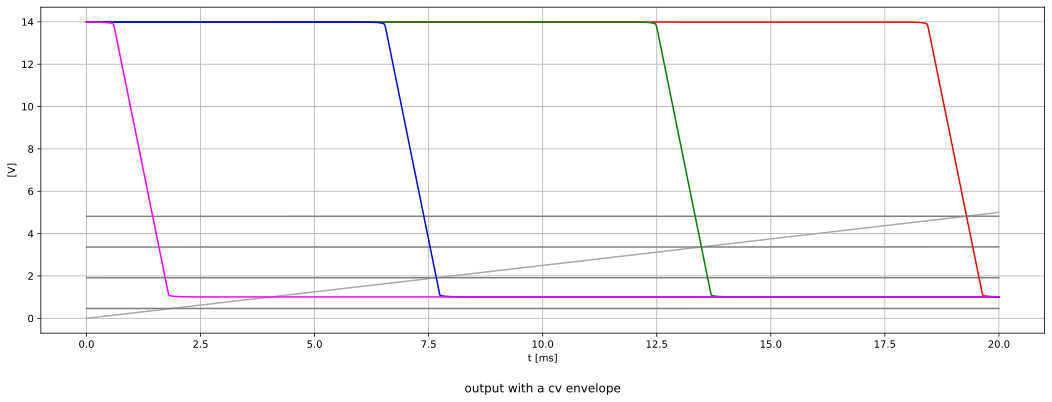

In [8]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
ax0.plot(analysis_scanner['CV_S'].abscissa*1000, analysis_scanner['CV_S'], c='DarkGrey')  # envelope input (scaled)

#plot the voltages
ax0.plot(analysis_scanner['Net-_R1-Pad2_'].abscissa*1000, analysis_scanner['Net-_R1-Pad2_'], c='Grey')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_R2-Pad2_'].abscissa*1000, analysis_scanner['Net-_R2-Pad2_'], c='Grey')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_R3-Pad2_'].abscissa*1000, analysis_scanner['Net-_R3-Pad2_'], c='Grey')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_R4-Pad2_'].abscissa*1000, analysis_scanner['Net-_R4-Pad2_'], c='Grey')  # envelope input (scaled)

#plot output of the opamps
ax0.plot(analysis_scanner['Net-_Q1-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q1-Pad2_'], c='Red')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q4-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q4-Pad2_'], c='Green')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q2-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q2-Pad2_'], c='Blue')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q3-Pad2_'].abscissa*1000, analysis_scanner['Net-_Q3-Pad2_'], c='Magenta')  # envelope input (scaled)

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()


In [17]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot cv
#ax0.plot(analysis_scanner['CV_S'].abscissa*1000, analysis_scanner['CV_S'], c='DarkGrey')  # envelope input (scaled)

#plot the voltages
ax0.plot(analysis_scanner['CV_S'].abscissa*1000, u_mA(analysis_scanner['vq1_collector']), c='Grey')  # envelope input (scaled)

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

2020-12-13 14:17:48,267 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT


IndexError: vq1_collector

2020-12-13 14:16:00,017 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:16:00,021 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:16:00,025 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:16:00,030 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT


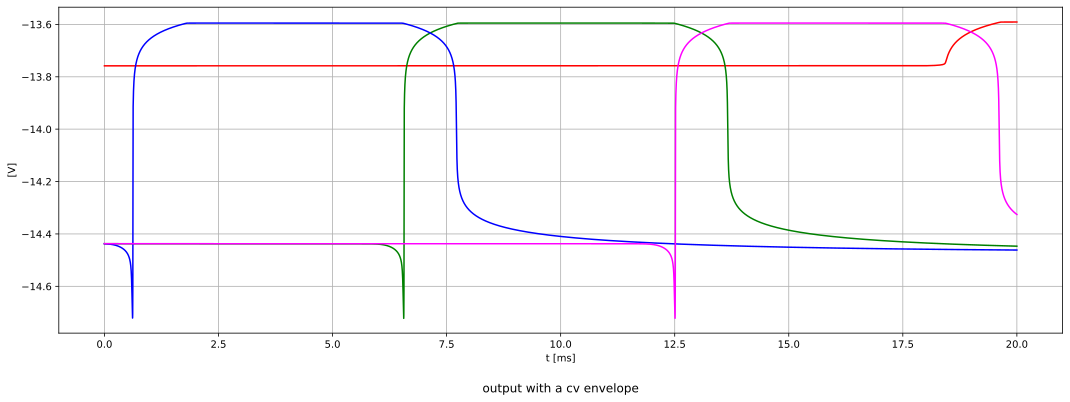

In [10]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot the envelopes
ax0.plot(analysis_scanner['Net-_Q1-Pad3_'].abscissa*1000, analysis_scanner['Net-_Q1-Pad3_'], c='Red')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q2-Pad3_'].abscissa*1000, analysis_scanner['Net-_Q2-Pad3_'], c='Green')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q3-Pad3_'].abscissa*1000, analysis_scanner['Net-_Q3-Pad3_'], c='Blue')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q4-Pad3_'].abscissa*1000, analysis_scanner['Net-_Q4-Pad3_'], c='Magenta')  # envelope input (scaled)

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

In [11]:
#simulate interpolating scanner
scanner = parser.build_circuit(ground=5)
scanner.include(spice_library['TL072'])
scanner.include(spice_library['TL072c'])
scanner.include(spice_library['LT1014x_30V'])
scanner.include(spice_library['BC556B'])
#scanner.include(spice_library['BC857CW'])
scanner.include(spice_library['LM13700/NS'])
scanner.include(spice_library['LM13700d'])
scanner.include(spice_library['D1N4148'])
scanner.V('1', '+15V', scanner.gnd, 'DC 15')
scanner.V('2', '-15V', scanner.gnd, 'DC -15')
scanner.V('3', 'IN_1', scanner.gnd, 'DC 0V AC 0V SIN(0 1V 400)')
scanner.V('4', 'IN_2', scanner.gnd, 'DC 0V AC 0V SIN(0 1V 800)')
scanner.V('5', 'IN_3', scanner.gnd, 'DC 0V AC 0V SIN(0 1V 1200)')
scanner.V('6', 'IN_4', scanner.gnd, 'DC 0V AC 0V SIN(0 1V 1600)')
scanner.V('7', 'CV_IN', scanner.gnd, 'DC 0V AC 0V PULSE(0V 5V 0 20m 0m 1u 20m)') 
simulator = scanner.simulator(temperature=25, nominal_temperature=25)
analysis_scanner = simulator.transient(step_time=1@u_us, end_time=40@u_ms)


2020-12-13 14:16:01,122 - PySpice.Spice.Parser.Element.build - DEBUG - R 6 ['Net-_R4-Pad2_', 'GND'] ['15k'] {}
2020-12-13 14:16:01,123 - PySpice.Spice.Parser.Element.build - DEBUG - R 4 ['Net-_R3-Pad2_', 'Net-_R4-Pad2_'] ['47k'] {}
2020-12-13 14:16:01,124 - PySpice.Spice.Parser.Element.build - DEBUG - R 3 ['Net-_R2-Pad2_', 'Net-_R3-Pad2_'] ['47k'] {}
2020-12-13 14:16:01,127 - PySpice.Spice.Parser.Element.build - DEBUG - R 2 ['Net-_R1-Pad2_', 'Net-_R2-Pad2_'] ['47k'] {}
2020-12-13 14:16:01,129 - PySpice.Spice.Parser.Element.build - DEBUG - R 1 ['+15V', 'Net-_R1-Pad2_'] ['330k'] {}
2020-12-13 14:16:01,131 - PySpice.Spice.Parser.Element.build - DEBUG - R 7 ['Net-_R12-Pad2_', 'CV_S'] ['47k'] {}
2020-12-13 14:16:01,134 - PySpice.Spice.Parser.Element.build - DEBUG - R 8 ['Net-_R13-Pad2_', 'CV_S'] ['47k'] {}
2020-12-13 14:16:01,137 - PySpice.Spice.Parser.Element.build - DEBUG - R 9 ['Net-_R14-Pad2_', 'CV_S'] ['47k'] {}
2020-12-13 14:16:01,138 - PySpice.Spice.Parser.Element.build - DEBUG - R 1

In [12]:
for nodes in analysis_scanner.branches :
    print( nodes )
    

a$poly$e.xu1.egnd#bra
a$poly$e.xu2.egnd#bra
a$poly$e.xu3.egnd#bra
a$poly$e.xu4.egnd#bra
a$poly$e.xu11.e.xu1a.egnd#bra
a$poly$e.xu11.e.xu1b.egnd#bra
a$poly$e.xu7.e.xu1a.egnd#bra
a$poly$e.xu7.e.xu1b.egnd#bra
a$poly$e.xu9.e.xu1a.egnd#bra
a$poly$e.xu9.e.xu1b.egnd#bra
v.xu5.v.xu1a.v4
v.xu5.v.xu1a.v5
v.xu5.v.xu1a.v6
v.xu5.v.xu1a.v7
v.xu5.v.xu1b.v4
v.xu5.v.xu1b.v5
v.xu5.v.xu1b.v6
v.xu5.v.xu1b.v7
v.xu6.v.xu1a.v4
v.xu6.v.xu1a.v5
v.xu6.v.xu1a.v6
v.xu6.v.xu1a.v7
v.xu6.v.xu1b.v4
v.xu6.v.xu1b.v5
v.xu6.v.xu1b.v6
v.xu6.v.xu1b.v7
v.xu1.vb
v.xu1.vc
v.xu1.ve
v.xu1.vlp
v.xu1.vln
v.xu2.vb
v.xu2.vc
v.xu2.ve
v.xu2.vlp
v.xu2.vln
v.xu3.vb
v.xu3.vc
v.xu3.ve
v.xu3.vlp
v.xu3.vln
v.xu4.vb
v.xu4.vc
v.xu4.ve
v.xu4.vlp
v.xu4.vln
v.xu11.v.xu1a.vb
v.xu11.v.xu1a.vc
v.xu11.v.xu1a.ve
v.xu11.v.xu1a.vlp
v.xu11.v.xu1a.vln
v.xu11.v.xu1b.vb
v.xu11.v.xu1b.vc
v.xu11.v.xu1b.ve
v.xu11.v.xu1b.vlp
v.xu11.v.xu1b.vln
v.xu7.v.xu1a.vb
v.xu7.v.xu1a.vc
v.xu7.v.xu1a.ve
v.xu7.v.xu1a.vlp
v.xu7.v.xu1a.vln
v.xu7.v.xu1b.vb
v.xu7.v.xu1b.vc
v.xu

2020-12-13 14:16:47,668 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:16:47,674 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:16:47,684 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT
2020-12-13 14:16:47,689 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT


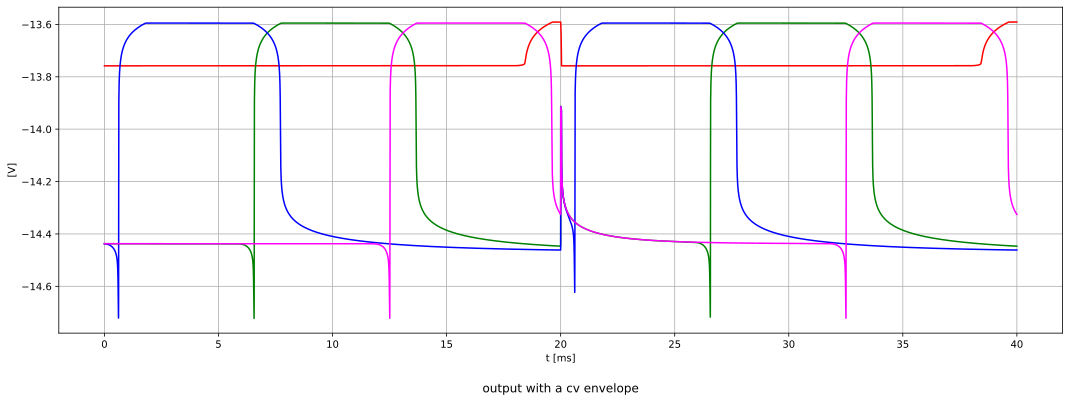

In [13]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot with envelope
ax0.plot(analysis_scanner['Net-_Q1-Pad3_'].abscissa*1000, analysis_scanner['Net-_Q1-Pad3_'], c='Red')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q2-Pad3_'].abscissa*1000, analysis_scanner['Net-_Q2-Pad3_'], c='Green')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q3-Pad3_'].abscissa*1000, analysis_scanner['Net-_Q3-Pad3_'], c='Blue')  # envelope input (scaled)
ax0.plot(analysis_scanner['Net-_Q4-Pad3_'].abscissa*1000, analysis_scanner['Net-_Q4-Pad3_'], c='Magenta')  # envelope input (scaled)

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

2020-12-13 14:16:49,024 - PySpice.Probe.WaveForm.WaveForm.__array_ufunc__ - DEBUG - Conversion for <ufunc 'multiply'> is NEW_UNIT


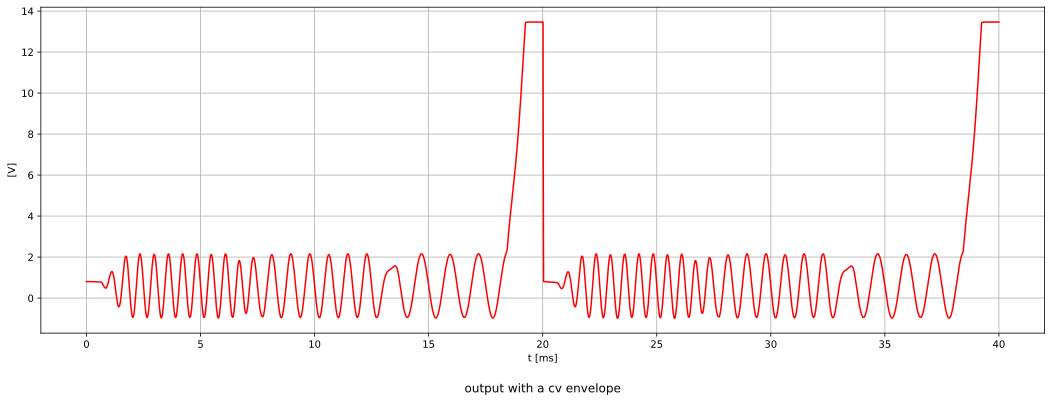

In [14]:
#plot the results
fig, ax0 = plt.subplots(figsize=(18, 6))

#plot with envelope
ax0.plot(analysis_scanner['OUT'].abscissa*1000, analysis_scanner['OUT'], c='Red')  # envelope input (scaled)

ax0.grid()
ax0.set_xlabel('t [ms]')
ax0.set_ylabel('[V]')
ax0.set_title('output with a cv envelope', y=-0.2)

plt.show()

## *construction*

for the final circuit input and output buffering and biasing is needed. the buffering is done with opamps. 


first we design the input stage. the input voltage for the X signal should be 10mV and 20mV for the control voltage.


## *references*

- [Muffwigler][1] thread with schematic from electrouwe

[1]: https://www.muffwiggler.com/forum/viewtopic.php?f=17&t=241171&start=25




In [15]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_input_audio (__main__.TestInputVoltages) ... ok
test_input_cv (__main__.TestInputVoltages) ... ok
test_voltage_divider (__main__.TestVoltageDivider) ... FAIL

FAIL: test_voltage_divider (__main__.TestVoltageDivider)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-7-993662c72d40>", line 4, in test_voltage_divider
    self.assertAlmostEqual(4.5@u_V, np.average( np.array( analysis_scanner[ 'Net-_R1-Pad2_' ] ) ), places=1, msg='voltage divider R1')
AssertionError: UnitValue(4.5 V) != 4.816883641700456 within 1 places (0.31688364170045613 difference) : voltage divider R1

----------------------------------------------------------------------
Ran 3 tests in 0.012s

FAILED (failures=1)
